In [3]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import re
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [4]:
def split_sent(text:str)->list:
    # split 시 무시할 패턴 정의    
    # 숫자. 로 끝나는 경우(숫자 .제외)보다 숫자. 로 시작하는 경우가 많다고 가정함
    #check = '(eqs?\.)|(figs?\.)|(sec\.)|(et\.\set\.)|(et\.?\sal\.?)|(e\.g\.)|(i\.e\.)|(no\.)|([0-9]\.)|(vs\.)|(ref\.)|(cf\.)'
    check = """ (eqs?\.)|(figs?\.)|(sec\.)|(et\.\set\.)|(et\.?\sal\.?)|(e\.g\.)|(i\.e\.)|(no\.)\
      |^([0-9]\.)$|(.?[0-9]+\.)$|(vs\.)|(ref\.)|(cf\.)\ # 논문 관련 약자들
      |(\s?\[\s?\w+\s?\w*\]) | (\<\w+\>) | (【\w+=?\w*】\s?) | ([\(\)])\ #괄호문자
      |(www\.)|(\.?\s?[a-z]+\.)|(\s?[a-z]+\.)\ # 링크주소1 www. segye. co
      |(\s+[가나다라마바사아자차카타파하]\.)
      |(\s+[ⅠⅠⅡⅢⅣⅤⅩ]+\.)
      """ 
    pp = re.compile(check, re.VERBOSE|re.IGNORECASE)
    
    # 문장부호에 특수문자가 붙거나 유니코드일 경우 처리
    text = cleansing(text)
    
    # 예외처리: 문장 끝에 .(공백없음)으로 끝나거나 .이 없는 경우
    sample = new_sample(text)
    splited_list = []
    prev_end = 0
    
    # .으로 끝나는 모든 경우를 find
    for sent in re.finditer('(\.\s?)|(\?\s)', sample):
        start = sent.span()[0]
        end = sent.span()[1]
        
        if start < 8:
            token = sample[start-start:end-1]
        else:
            token = sample[start-8:end-1]

        # '. ' 앞뒤에 check에 해당하는 패턴이 없는 경우 문장으로 나누기
        if pp.search(token) == None:
            # [0-9]+㎡, 날짜정보 예외처리 0000.00.00.
            # print(token)
            except_pattern_date_1 = re.search('([0-9]{4}\.\s?[0-9]+\.\s?[0-9]+\.?)', sample[start-8:end+7])
            # print(sample[start-4:end+7])
            except_pattern_date_21 = re.search('([0-9]{4}\.\s?[0-9]+\.\s?[0-9]+\.?)', sample[start-8:end+3])
            except_pattern_date_22 = re.search('.?([0-9]{4}\.\s?[0-9]+\.?)', sample[start-8:end])
            # print(sample[start-7:end])
            # print(sample[start-7:end+3])
            except_pattern_date_3 = re.search('.?([0-9]{4}\.\s?[0-9]+\.\s?[0-9]+\.?)', sample[start-12:end])
            #print(sample[start-12:end])
            except_pattern_date_check = (except_pattern_date_1 == None)&(except_pattern_date_21 ==None)\
            &(except_pattern_date_22 ==None)&(except_pattern_date_3==None)
            
            except_pattern_etc = re.search('[0-9]+\.\s?[0-9]+㎡', sample[start-8:end+4])
            
            if (except_pattern_date_check) & (except_pattern_etc == None) :
                            
                # . 2) 처럼 뒤에 주석이 있는 경우 문장으로 나누기                
                # 주석이 있다면
                if re.search('\.\s?([0-9]+\))', sample[start:end+4]):
                    juseok_info = list(re.finditer('\.?([0-9]+\)\s*)', sample[start:end+8].strip()))
                    juseok = [ji.group() for ji in juseok_info] 
                    
                    # 주석이 2개 이상이라면(2개까지만 고려)
                    if len(juseok) > 1:
                        # print('juseok: ', juseok)
                        tmp = sample[prev_end:end+3].strip()+juseok[-1].strip()
                        # print(tmp)
                        prev_end = end+juseok_info[-1].span()[1]
                        # print(prev_end)
                    else:
                        tmp = sample[prev_end:end+3].strip()
                        prev_end = end+3
                    try:
                        if re.search('\.', tmp[-1]):
                            tmp = tmp[:-1]
                    except:
                        pass

                    
                    splited_list.append(tmp)

                # original
                else:
                    splited_list.append(sample[prev_end:end-1].strip())
                    prev_end = end
            
        elif pp.search(token) != None:
            # 마지막일 경우
            if len(sample) == end:
                splited_list.append(sample[prev_end:end-1].strip())

    return splited_list


# '.●'와 같은 특이 케이스 처리를 위해 추가(10.5)
# '６８.'특수문자 처리 안 함 
def cleansing(text):
    text = text
    cleansed_text = ''
    
    try:
    # 유니코드 문자 제거
        pattern1 = """(\\uf076)|(\xa0)"""
        p1 = re.compile(pattern1, re.VERBOSE)
        cleansed_text = p1.sub("", text)
        cleansed_text = cleansed_text.strip() 
    except:
        pass
    
    try:
        # 특수기호 앞 공백 추가
        pattern2 = """[■▦◆▲●▶▽△◇©ⓒ①②③④⑤⑥⑦®㈜※【】]  #특수문자"""
        p2 = re.compile(pattern2, re.VERBOSE)
        
        match_list = [ m.group() for m in p2.finditer(cleansed_text)]
        match_list= list(set(match_list))

        for match in match_list:
            h = Substitutable(cleansed_text)
            cleansed_text = h.sub(match, ' '+match)
    except:
        pass
    
    try:
        # 마침표 특수문자 case 처리
        pattern2 = "．"
        p3 = re.compile(pattern2)
        cleansed_text = p3.sub(".", cleansed_text)
    except:
        pass

    return cleansed_text


# ref. https://stackoverflow.com/questions/15175142/how-can-i-do-multiple-substitutions-using-regex
class Substitutable(str):
    def __new__(cls, *args, **kwargs):
        newobj = str.__new__(cls, *args, **kwargs)
        newobj.sub = lambda fro,to: Substitutable(re.sub(fro, to, newobj))
        return newobj



def new_sample(sample):
    try:
        if sample[-2:] == '. ':
            new_sample = sample

        elif sample[-1] == '.':
            new_sample = sample+' '

        elif sample[-1] != '.':
            new_sample = sample+'. '

        else:
            print('please check the data!')
    except:
        new_sample = sample
        
    return new_sample


In [5]:
def split_chapter(origi_:str)->list:
    reg = re.compile("\[\[CHAPTER\]\] +(\w+) +\[\[BODY\]\] +(\w+)-?(\w+)?")
    spli_ = find_chapter(origi_,reg)
    if spli_ != []:
        pass
    elif spli_ == []:
        reg = re.compile("CHAPTER")
        spli_ = find_chapter(origi_,reg)
    if spli_ != []:
        data_all = []
        for i in range(len(spli_)):
            chap = spli_[i][0]
            try:
                star_ = spli_[i][1][1]
                end_ = spli_[i+1][1][0]
                data_ = origi_[star_:end_].split("  ")
            except:
                star_ = spli_[i][1][1]
                data_ = origi_[star_:].split("  ")
            data_all.append([chap,data_])
    else:
        data_all = []
    return data_all

def find_chapter(origi_,reg):
    spli_ = []
    for i in reg.finditer(origi_):
        spli_.append([i.group(),i.span()])
    return spli_

In [126]:
def to_nextsentence(df_):
    stack_all = []
    for i in range(len(df_)):
        paras = df_["paragraph"][i]
        for i2 in range(len(paras)):
            try:
                sen1 = paras[i2]
                sen2 = paras[i2+1]
                stack_all.append([sen1,sen2])
            except:
                stack_all.append(["",""])
    return pd.DataFrame(stack_all).rename(columns={0:"sen1",1:"sen2"})

In [127]:
def loading_data(path_1,reg):
    os.chdir(path_1)
    tq = tqdm(os.listdir())
    fn_list = []
    for i in tq:
        if i.endswith(".txt"):
            fn_ = reg.findall(i.replace(".","_"))[0]
            fn_ = fn_.split("_")[0]
            fn_list.append([fn_,i])
            print(fn_)

            f = open(path_1+"\\"+i, 'rt',encoding="iso-8859-1")
            globals ()["{}".format(fn_)] = ""
            line = f.read()
            try:
                line = bytes(line,"iso-8859-1").decode("utf-8")
            except:
                try:
                    line = bytes(line,"iso-8859-1").decode("utf-16")
                except:
                    try:
                        line = bytes(line,"iso-8859-1").decode("euc-kr")
                    except:
                        line = bytes(line,"iso-8859-1").decode("cp949")
            globals ()["{}".format(fn_)] = globals ()["{}".format(fn_)] + line
             #print(line)
            f.close()
    return fn_list

In [128]:
def First_preprocessing(fn_s):
    # Rule 2: # strip \t, \xa0 관련 제거하기
    origi_ = [i.strip().replace("\t"," ").replace("\xa0","") for i in fn_s ]
    
    # Rule 1: 2칸 이상의 enter은 space 2칸으로 대체한다.
    original_all = re.sub(' {2,}','  ', " ".join(origi_))
        ## Rule 1+: . 두개 이상은 .로 대체한다.
        ##original_all = re.sub('.{2,}',"", original_all)
    
    # Rule 2: sentence split (1. 2칸의 공백 / 2. 다로 끝나는것 / 3. ). 로 끝나는 것
        # 나. 뭐시기 뭐시기 .... 다. 뭐시기 의 다. 같은 경우가 있어서 *이 아니라 +로 쓴다.
    reg = re.compile(" {2,}|.+?다[.]|.*?[)][.]")
    or_ = reg.findall(original_all)
    # Rule 3. Sentence split (다로 끝나는 것 중에서 ")."를 포함한것)
    or_all = []
    for i in or_:
        tar_ = ")."
        if tar_ in i:
            can_ = i.split(tar_)
            can_2 = [i2 +tar_ for i2 in can_[:-1]]
            can_2.append(can_[-1])
            or_all.extend(can_2)
        else:
            or_all.append(i)
    # Rule 4+ : strip 한번더 하기
    or_all = list(map(lambda x: x.strip() if x != "  " else "  ",or_all))
    # Rule 4: "다." 혼자 있으면 나머지랑 합치기
    index_ = []
    for i in range(len(or_all)):
        if or_all[i] == "다.":
            try:
                after_ = or_all[i]  + " " + or_all[i+1]
                index_in = i
                index_.append([index_in,after_])
            except:
                pass
    for i in index_:
        ind_ = i[0]
        txt_ = i[1]
        or_all[ind_] = txt_
    for i in index_:
        del_in = i[0]+1
        try:
            del or_all[del_in]
        except:
            pass
    #or_all,remove_all = eliminate_short("cha",4,or_all)
    
    return or_all

def eliminate_short(version,tar_len,sp_):
    tar_sen = []
    remove_sen = []
    for i in sp_:
        if i =="  ":
            tar_sen.append(i)
        else:
            if version =="cha":
                if len(i) >= tar_len:
                    tar_sen.append(i)
                else:
                    remove_sen.append(i)
            elif version =="word":
                if len(i.split(" ")) >= tar_len:
                    tar_sen.append(i)      
                else:
                    remove_sen.append(i)
    return tar_sen, remove_sen


In [129]:
def First(fn_list):
    error = []
    none_error = []
    remove_list = []
    tq = tqdm(fn_list)
    
    comparison = []
    
    for fn_,fn_2 in tq:
        test_ = globals ()["{}".format(fn_)]
        
        fn_s = test_.splitlines()
        origi_ = re.sub(' {2,}','  ', " ".join(fn_s))
        origi_ = First_preprocessing(fn_s)
        origi_ = re.sub(' {2,}','  ', " ".join(origi_))
        
        # chapter 별로 나누기
        data_all = split_chapter(origi_)

        if data_all != []: 
            none_error.append([fn_,fn_2])
            # dataframne 만들기
            df_data = []
            for data_ in data_all:
                chap_ = data_[0]
                paras_ = data_[1]
                sents_ = []
                for para_ in paras_:
                    sen_ = split_sent(para_)
                    sen_,remove_all = eliminate_short("cha",10,sen_)
                    remove_list.extend(remove_all)
                    
                    ## [[ABSTRACT]] 같은거 지우기 + 길이가 0인것 지우기 + ")." 지우기
                    reg_2 = re.compile(r"\[\[\w+]\]|\)\.|\.|\):\.|〃.")
                    remove_ = [a2 for a2 in sen_ if reg_2.match(a2)]
                    if len(remove_) == 0 and len(sen_)!= 0:
                        sents_.extend(sen_)
                    else:
                        pass
                df_data.append([chap_,sents_])
            df_ = pd.DataFrame(df_data).rename(columns={0:"Chapter",1:"paragraph",2:"sentences"})

            # Next sentence 형태로 만들기
            df_next = to_nextsentence(df_)
            df_next.to_excel(save_path + "\\" + fn_ + ".xlsx")
            
            # 변한된 데이터 오리진 데이터와 비교
            modi_len = df_next["sen1"].map(lambda x: len(x)).sum()
            ori_len = len(test_)
            comparison.append([fn_,ori_len,modi_len])
            
        else:
            error.append([fn_,fn_2])
    return error,remove_list,comparison


In [130]:
def nara_processing(path):

    f = open(path, 'rt',encoding="iso-8859-1")
    line = f.readlines()
    try:
        texts = [bytes(li,"iso-8859-1").decode("utf-8") for li in line]
    except:
        try:
            texts = [bytes(li,"iso-8859-1").decode("utf-16") for li in line]
        except:
            try:
                texts = [bytes(li,"iso-8859-1").decode("euc-kr") for li in line]
            except:
                try:
                    texts = [bytes(li,"iso-8859-1").decode("cp949") for li in line]
                except:
                    #texts = [bytes(li,"iso-8859-1").decode("utf-8-sig") for li in line]
                    print("error occurs")
                    return ""
                    
    # \n 제거
    texts = [re.sub('\\n', '', t) for t in texts]

    # paragraph split
    texts = split_para_nara(texts)

    # .. ). 제거
    texts = [re.sub('\.{2,}', '. ', t) for t in texts]
    texts = [re.sub('\)\.\s?', '). ', t) for t in texts]
    
    return texts



def split_para_nara(sents):
    new_page = []

    save_text = ''
    prev = 0


    for i in range(len(sents)):
        text = sents[i] # .strip()
        # A. B. 추가, $
        if re.match('(^[0-9]+\)[\s+]?)?(\s?[A-Z])', text):
            # 이전 문장 저장
            # 이전 문장에 주석이 존재할 경우 주석 포함
            f_info = re.search('(^[0-9]+\)[\s+]?)', text)

            if f_info: 
                f_info_group = re.sub('[\.\s]', '', f_info.group())
                new_page.append(save_text+'.'.join(sents[prev:i])+'.'+f_info_group)
                save_text = ''
                save_text = text[f_info.span()[1]:]+'.'

            # 주석 없는 경우
            else:
                new_page.append(save_text+'.'.join(sents[prev:i])+'.')
                save_text = ''
                save_text = text+'.'
            prev = i+1


        # 숫자. 텍스트 형태(+앞에 주석이 있을 경우 예외 추가), $
        if re.match('(^[0-9]+\)[\s+]?)?(\s?[0-9]{1})', text):     
            # 이전 문장 저장
            # 이전 문장에 주석이 존재할 경우 주석 포함
            f_info = re.search('(^[0-9]+\)[\s+]?)', text)

            if f_info: 
                f_info_group = re.sub('[\.\s]', '', f_info.group())
                new_page.append(save_text+'.'.join(sents[prev:i])+'.'+f_info_group)
                save_text = ''
                save_text = text[f_info.span()[1]:]+'.'

            # 주석 없는 경우
            else:
                new_page.append(save_text+'.'.join(sents[prev:i])+'.')
                save_text = ''
                save_text = text+'.'
            prev = i+1


        # 로마자. 텍스트 형태 $
        roma =  '(^[0-9]+\)[\s+]?)?[ⅠⅠⅡⅢⅣⅤⅩ]+'
        if re.match(roma, text):  
            # 이전 문장 저장
            # 이전 문장에 주석이 존재할 경우 주석 포함
            f_info = re.search('(^[0-9]+\)[\s+]?)', text)

            if f_info: 
                f_info_group = re.sub('[\.\s]', '', f_info.group())
                new_page.append(save_text+'.'.join(sents[prev:i])+'.'+f_info_group)
                save_text = ''
                save_text = text[f_info.span()[1]:]+'.'

            # 주석 없는 경우
            else:
                new_page.append(save_text+'.'.join(sents[prev:i])+'.')
                save_text = ''
                save_text = text+'.'

            prev = i+1


        # (1) 텍스트 형태(+앞에 주석이 있을 경우 예외 추가) $
        # (가) 텍스트 형태 추가
        if re.match('(^[0-9]+\)[\s+]?)?\s?\([0-9]\)|(^[0-9]+\)[\s+]?)?\s?\([가나다라마바사아자차카타파하]\)', text):
            # 이전 문장 저장
            # 이전 문장에 주석이 존재할 경우 주석 포함
            f_info = re.search('(^[0-9]+\)[\s+]?)', text)

            if f_info: 
                f_info_group = re.sub('[\.\s]', '', f_info.group())
                new_page.append(save_text+'.'.join(sents[prev:i])+'.'+f_info_group)
                save_text = ''

            # 주석 없는 경우
            else:
                new_page.append(save_text+'.'.join(sents[prev:i])+'.')
                save_text = ''

            prev = i


    new_page.append(save_text+' '.join(sents[prev:])) # split 사용 시: .으로 조인했었음 
    new_page = [sent for sent in new_page if sent != '.'] 


    if new_page[0][0] == '.':
        new_page = new_page[0][1:]

    return new_page

In [131]:
def Second(error,path_1,save_path):
    remove_list = []
    tq = tqdm(error)
    error_2 = []
    comparison = []
    
    for i,i_4 in tq:
        print(i)
        path_test = path_1 + "\\" + i_4
        nara_ = nara_processing(path_test)
        naras_list = []
        for na_ in nara_:
            naras_list.append(First_preprocessing([na_]))
        if naras_list != []:
            df_data = []
            for i2 in range(len(naras_list)):
                chap_ = ""
                paras_ = " ".join(naras_list[i2])
                sen_ = split_sent(paras_)
                sen_,remove_all = eliminate_short("cha",4,sen_)
                remove_list.extend(remove_all)
                ## [[ABSTRACT]] 같은거 지우기 + 길이가 0인것 지우기 + ")." 지우기
                reg_2 = re.compile(r"\[\[\w+]\]|\)\.|\.|\):\.|〃.")
                remove_ = [a2 for a2 in sen_ if reg_2.match(a2)]
                if len(remove_) == 0 and len(sen_)!= 0:
                    df_data.append([chap_,sen_])
                else:
                    pass
            df_ = pd.DataFrame(df_data).rename(columns={0:"Chapter",1:"paragraph",2:"sentences"})
            # Next sentence 형태로 만들기
            df_next = to_nextsentence(df_)
            df_next.to_excel(save_path + "\\" + i + ".xlsx")
            
            # 변한된 데이터 오리진 데이터와 비교
            modi_len = df_next["sen1"].map(lambda x: len(x)).sum()
            ori_len = sum(list(map(lambda x: len(x),nara_)))
            comparison.append([i,ori_len,modi_len])
            
        else:
            error_2.append(i)
    return error_2,remove_list,comparison



# Hanyang 

In [215]:
path_1 = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\hanyang\00 변환"
reg = re.compile(r"result_([a-zA-Z0-9_]+)_")
save_path = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\result_3\hanyang"

In [216]:
fn_list = loading_data(path_1,reg)

  0%|          | 0/27 [00:00<?, ?it/s]

1092
LB0026
LP0037
LP0077
LP0095
LP0752
LP0753
LP0754
LP0756
LP0757
LP0779
LP0790
LP0794
LP0796
LP0797
LP0801
LP0804
LP0805
LP0809
LP0811
LP0869
LP0876
LP0886
LP1025
LP1111
LP1113
LP328


In [217]:
error,remove_list,compa_list = First(fn_list)

  0%|          | 0/27 [00:00<?, ?it/s]

In [218]:
compa_list = [i + ["Hanyang"] for i in compa_list]

# Korea

In [219]:
path_1 = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\4-3 고대언어검토완-20230104T085410Z-001\4-3 고대언어검토완"
reg = re.compile(r"result_([a-zA-Z0-9_]+)_")
save_path = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\result_3\korea"

In [220]:
fn_list = loading_data(path_1,reg)

  0%|          | 0/43 [00:00<?, ?it/s]

LB0043
LB0131
LB0135
LB0285
LB0294
LB0297
LB0301
LP0052
LP0063
LP0151
LP0181
LP0257
LP0343
LP0381
LP0394
LP0550
LP0557
LP0716
LP1110
LP1174
ME0031
ME0034
ME0035
ME0039
ME0041
ME0045
ME0076
ME0094
ME0161
ME0172
ME0190
ME0197
ME0211
ME0236
ME0246
ME0253
ME0256
ME0274
MK0055
MK0060
MK0125
MK0159
MK0181


In [221]:
error,remove_list_2,compa_list_2 = First(fn_list)

  0%|          | 0/43 [00:00<?, ?it/s]

In [222]:
error

[]

In [223]:
compa_list_2 = [i + ["Korea"] for i in compa_list_2]

# Nara

In [224]:
path_1 = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\nara\00 변환"
reg = re.compile(r"(\w+)_")
save_path = r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\result_3\nara"

In [225]:
fn_list = loading_data(path_1,reg)

  0%|          | 0/281 [00:00<?, ?it/s]

LB0033
LB0035
LB0052
LB0055
LB0057
LB0062
LB0064
LB0074
LB0079
LB0082
LB0085
LB0086
LB0088
LB0099
LB0114
LB0118
LB0121
LB0134
LB0171
LB0173
LB0212
LB0217
LB0233
LB0246
LB0251
LB0260
LB0272
LB0293
LB0298
LB0307
LB0327
LB0328
LB0342
LB0349
LP0020
LP0026
LP0122
LP0153
LP0154
LP0161
LP0204
LP0212
LP0241
LP0243
LP0246
LP0253
LP0273
LP0277
LP0298
LP0324
LP0333
LP0366
LP0389
LP0390
LP0391
LP0420
LP0421
LP0433
LP0434
LP0477
LP0483
LP0497
LP0498
LP0529
LP0533
LP0537
LP0542
LP0569
LP0717
LP0721
LP0723
LP0751
LP0755
LP0758
LP0759
LP0760
LP0762
LP0763
LP0764
LP0765
LP0784
LP0785
LP0786
LP0787
LP0788
LP0789
LP0792
LP0793
LP0795
LP0806
LP0807
LP0808
LP0810
LP0884
LP0885
LP0887
LP0899
LP0904
LP0919
LP0929
LP0932
LP0933
LP0942
LP0955
LP0956
LP0958
LP0976
LP1002
LP1018
LP1021
LP1026
LP1040
LP1069
LP1075
LP1081
LP1086
LP1088
LP1089
LP1090
LP1101
LP1105
LP1107
LP1113
LP1114
LP1120
LP1122
LP1124
LP1126
LP1134
LP1135
LP1136
LP1139
LP1141
LP1142
LP1151
LP1157
LP1159
LP1162
LP1164
LP1168
LP1173
ME0006
ME0007

In [226]:
error,remove_list_3,compa_list_3 = First(fn_list)

  0%|          | 0/281 [00:00<?, ?it/s]

In [227]:
error

[['LB0033', 'LB0033_교회분쟁관계법_nara.txt'],
 ['LB0035', 'LB0035_기술이전계약론_nara.txt'],
 ['LB0052', 'LB0052_상표법[제6판]_nara.txt'],
 ['LB0055', 'LB0055_신미국특허법_nara.txt'],
 ['LB0057', 'LB0057_영업비밀보호법[전면개정제3판]_nara.txt'],
 ['LB0062', 'LB0062_특허법[제6판]_nara.txt'],
 ['LB0064', 'LB0064_특허의이해[제5판]_nara.txt'],
 ['LB0074', 'LB0074_국제사법_nara.txt'],
 ['LB0079', 'LB0079_계약법_nara.txt'],
 ['LB0082', 'LB0082_물권법[제15판]_nara.txt'],
 ['LB0085', 'LB0085_민법강의[제28판]_nara.txt'],
 ['LB0086', 'LB0086_민법총칙[제16판]_nara.txt'],
 ['LB0088', 'LB0088_민법총칙[제4판]_nara.txt'],
 ['LB0099', 'LB0099_채권법[제13판]_nara.txt'],
 ['LB0114', 'LB0114_민사소송법강의[제2판]_nara.txt'],
 ['LB0118', 'LB0118_민사소송실무_nara.txt'],
 ['LB0121', 'LB0121_지적소송실무_nara.txt'],
 ['LB0134', 'LB0134_법학입문_nara.txt'],
 ['LB0171', 'LB0171_의료법강의[제4판]_nara.txt'],
 ['LB0212', 'LB0212_어음수표법[개정판]_nara.txt'],
 ['LB0217', 'LB0217_주식회사법대계[제4판]_nara.txt'],
 ['LB0233', 'LB0233_회사법강의[제8판]_nara.txt'],
 ['LB0246', 'LB0246_알기쉬운행정법총론[제6판]_nara.txt'],
 ['LB0251', 'LB0251_판례교재 행정법[제4판]_nara.tx

In [228]:
compa_list_3 = [i + ["nara_1"] for i in compa_list_3]

In [229]:
error_2,remove_list_3_2,compa_list_3_2 = Second(error,path_1,save_path)

  0%|          | 0/249 [00:00<?, ?it/s]

LB0033
LB0035
LB0052
error occurs
LB0055
LB0057
LB0062
LB0064
LB0074
LB0079
LB0082
LB0085
LB0086
LB0088
LB0099
LB0114
LB0118
LB0121
LB0134
LB0171
LB0212
LB0217
LB0233
LB0246
LB0251
LB0260
LB0272
LB0293
LB0298
LB0327
LB0328
LB0342
LB0349
LP0020
LP0026
LP0122
LP0153
LP0154
LP0161
LP0204
LP0212
LP0241
LP0243
LP0246
LP0253
LP0273
LP0277
LP0298
LP0324
LP0333
LP0366
LP0389
LP0390
LP0391
LP0420
LP0421
LP0433
LP0434
LP0477
LP0483
LP0497
LP0498
LP0529
LP0533
LP0537
LP0542
LP0569
error occurs
LP0717
LP0721
LP0723
LP0751
LP0755
LP0758
LP0759
LP0760
LP0762
LP0763
LP0764
LP0765
LP0784
LP0785
LP0786
LP0787
LP0788
LP0789
LP0792
LP0793
LP0795
LP0806
LP0807
LP0808
LP0810
LP0884
LP0885
LP0887
LP0899
LP0904
LP0919
LP0929
LP0932
LP0933
LP0942
LP0955
LP0956
LP0958
LP0976
LP1018
LP1021
LP1040
LP1075
LP1081
LP1086
LP1088
LP1089
LP1090
LP1101
LP1107
LP1113
LP1114
LP1120
LP1122
LP1124
LP1126
LP1134
LP1135
LP1136
LP1139
LP1141
LP1142
LP1151
LP1157
LP1159
LP1162
LP1164
LP1168
error occurs
ME0006
ME0007
ME0008
ME

In [230]:
compa_list_3_2 = [i + ["nara_2"] for i in compa_list_3_2]

In [231]:
error_2

['LB0052',
 'LP0569',
 'LP1168',
 'ME0009',
 'ME0135',
 'ME0299',
 'ME0309',
 'ME0316',
 'MK0064',
 'MK0089',
 'MK0101',
 'MK0111',
 'MK0211']

In [232]:
compa_list.extend(compa_list_2)

In [233]:
compa_list.extend(compa_list_3)
compa_list.extend(compa_list_3_2)

In [253]:
df_com = pd.DataFrame(compa_list).rename(columns={0:"Book",1:"Before",2:"After",3:"Refer"})

In [254]:
df_com

,Book,Before,After,Refer
0,1092,63121,61522,Hanyang
1,LB0026,941841,912676,Hanyang
2,LP0037,285039,264365,Hanyang
3,LP0077,453437,412857,Hanyang
4,LP0095,939662,922510,Hanyang
...,...,...,...,...
333,MK0165,5589,5498,nara_2
334,MK0178,112615,94869,nara_2
335,MK0182,1995,768,nara_2
336,MK0188,85242,70725,nara_2


In [255]:
Counter(list(df_com["Book"])).most_common()[0:5]

[('LP1113', 2), ('1092', 1), ('LB0026', 1), ('LP0037', 1), ('LP0077', 1)]

In [256]:
df_com["Retention(%)"] = df_com.apply(lambda x: (x["After"]/x["Before"])*100,axis=1)

In [257]:
df_com["Gap"] = df_com["Before"] - df_com["After"]

In [258]:
df_com

,Book,Before,After,Refer,Retention(%),Gap
0,1092,63121,61522,Hanyang,97.466770,1599
1,LB0026,941841,912676,Hanyang,96.903405,29165
2,LP0037,285039,264365,Hanyang,92.746957,20674
3,LP0077,453437,412857,Hanyang,91.050576,40580
4,LP0095,939662,922510,Hanyang,98.174663,17152
...,...,...,...,...,...,...
333,MK0165,5589,5498,nara_2,98.371802,91
334,MK0178,112615,94869,nara_2,84.241886,17746
335,MK0182,1995,768,nara_2,38.496241,1227
336,MK0188,85242,70725,nara_2,82.969663,14517


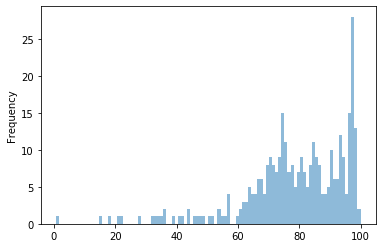

In [259]:
ax = df_com["Retention(%)"].plot.hist(bins=100, alpha=0.5)

In [260]:
df_com = df_com.sort_values(by=["Retention(%)"]).reset_index(drop=True)
df_com.loc[0:20]

,Book,Before,After,Refer,Retention(%),Gap
0,MK0240,262771,1896,nara_1,0.721541,260875
1,ME0220,352753,53550,nara_2,15.180594,299203
2,LB0173,1122066,207410,nara_1,18.484652,914656
3,ME0317,64607,13351,nara_2,20.664943,51256
4,MK0218,565004,121912,nara_1,21.577192,443092
5,ME0121,422719,118360,nara_2,27.999688,304359
6,ME0112,189365,60929,nara_1,32.175428,128436
7,MK0004,497188,163753,nara_2,32.935831,333435
8,MK0009,588781,200201,nara_2,34.002626,388580
9,ME0225,64289,22344,nara_1,34.755557,41945


In [268]:
df_com["Retention(%)"].mean()

78.88436822272624

In [264]:
df_com[df_com["Refer"]=="Hanyang"]["Retention(%)"].mean()

93.2181333684124

In [269]:
df_com[df_com["Refer"]=="Hanyang"]["Retention(%)"].var()

17.378244110158036

In [265]:
df_com[df_com["Refer"]=="Korea"]["Retention(%)"].mean()

94.22939832514494

In [270]:
df_com[df_com["Refer"]=="Korea"]["Retention(%)"].var()

29.592737096845504

In [266]:
df_com[df_com["Refer"]=="nara_1"]["Retention(%)"].mean()

79.02669251200122

In [271]:
df_com[df_com["Refer"]=="nara_1"]["Retention(%)"].var()

845.5614045871257

In [267]:
df_com[df_com["Refer"]=="nara_2"]["Retention(%)"].mean()

74.4292736015638

In [272]:
df_com[df_com["Refer"]=="nara_2"]["Retention(%)"].var()

195.69874262132777

In [273]:
df_com.to_excel(r"C:\Users\Samsung\jupyter\Project_Medical_Legal\data\20230104\result_3\Comparision.xlsx")